In [1]:
from pathlib import Path
from time import sleep

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 150

import datamate

%load_ext autoreload
%autoreload 2

# Introduction to Datamate

The notebook demonstrates datamate for storing and retrieving mockup measurements of locations, colors, and connectivity of brain cells.


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8c/Brainbow_%28Smith_2007%29.jpg/715px-Brainbow_%28Smith_2007%29.jpg" alt="drawing" style="width:50%" title="From Wikipedia: Mouse neurons labeled with fluorescent tags. Such “color coded” brain cells promise new solutions to formerly intractable problems with resolving closely packed neurons and tracing their axons and dendrites reliably over long distances. It seems unlikely that neural information processing will ever be understood without solving such problems and reconstructing circuits in far more detail that presently possible."/>

Image by Stephen J Smith, December 21, 2007: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2693015/

In [2]:
# we set the root directory. this is where our journey on the hierarchical filesystem starts

root_dir = Path(".") / "data"

# cleaning up
if root_dir.exists():
    import shutil

    shutil.rmtree(root_dir)

datamate.set_root_dir(root_dir)

## `Directory` as pointer to navigate a hierachical filesystem

In [3]:
# we create a first Directory instance pointing to a directory relative to root_dir.
cell_measurements = datamate.Directory()
cell_measurements

Directory_0000/
    (path does not exist)

Taking mockup cell measurements of identity, x- and y-coordinates and colors.

In [4]:
# we can store data by setting the Directory's attributes.
n_cells = 100
cell_measurements.cell_id = np.arange(n_cells)
cell_measurements.x = np.random.normal(0, 1, size=n_cells)
cell_measurements.y = np.random.normal(0, 1, size=n_cells)
cell_measurements.colors = np.random.rand(n_cells, 3)

In [5]:
# explore files and directories
cell_measurements

Directory_0000/ - Last modified: April 30, 2023 19:26:31
├── _meta.yaml
├── cell_id.h5
├── colors.h5
├── x.h5
└── y.h5

displaying: 1 directory, 5 files

Text(0.5, 1.0, 'Locations and colors of 100 cells')

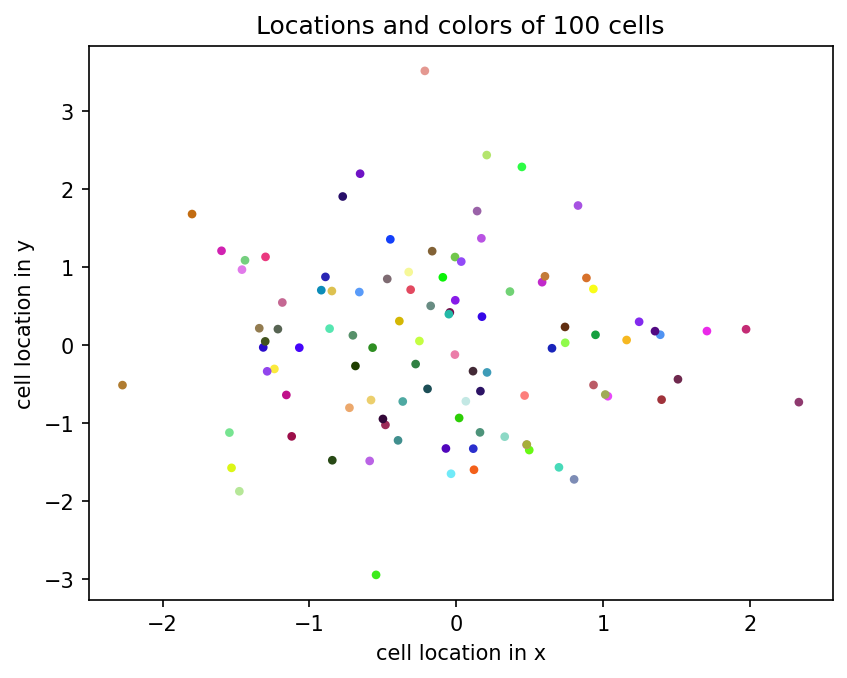

In [6]:
# and access data
plt.scatter(cell_measurements.x, cell_measurements.y, c=cell_measurements.colors, s=10)
plt.xlabel("cell location in x")
plt.ylabel("cell location in y")
plt.title(f"Locations and colors of {n_cells} cells")

Text(0.5, 1.0, 'Locations and colors of 50 cells')

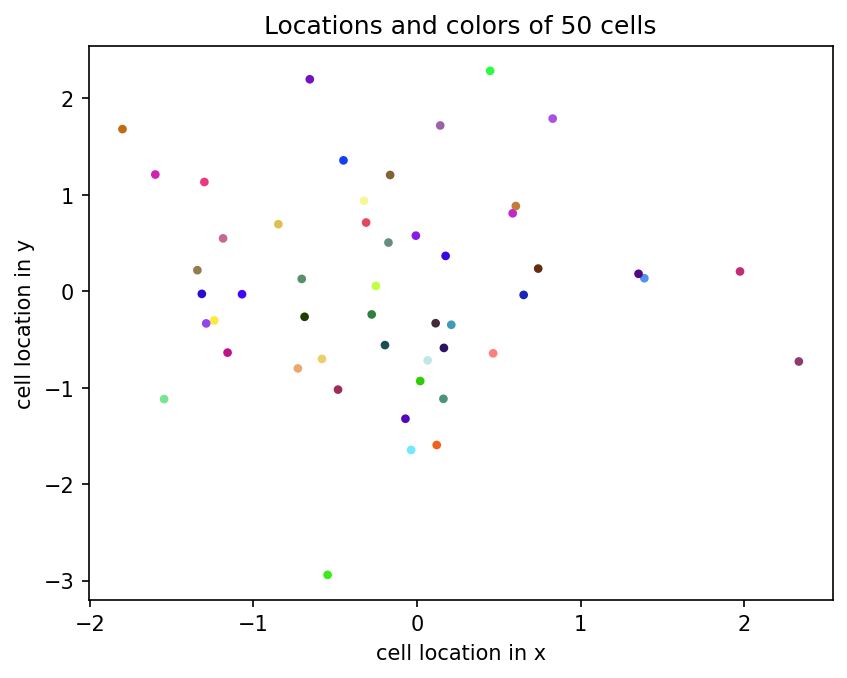

In [7]:
# we can index the h5-arrays from disk without fully loading them to memory for flexible memory usage
start_cell_id = 0
end_cell_id = 50
plt.scatter(
    cell_measurements.x[start_cell_id:end_cell_id],
    cell_measurements.y[start_cell_id:end_cell_id],
    c=cell_measurements.colors[start_cell_id:end_cell_id],
    s=10,
)
plt.xlabel("cell location in x")
plt.ylabel("cell location in y")
plt.title(f"Locations and colors of {end_cell_id - start_cell_id} cells")

In [8]:
# we can use the directory name point to the same directory again
cell_measurements = datamate.Directory("Directory_0000")

In [9]:
cell_measurements

Directory_0000/ - Last modified: April 30, 2023 19:26:31
├── _meta.yaml
├── cell_id.h5
├── colors.h5
├── x.h5
└── y.h5

displaying: 1 directory, 5 files

In [10]:
# we can navigate upwards on the filesystem hierarchy
cell_measurements.parent

data/ - Last modified: April 30, 2023 19:26:31
└── Directory_0000/
    ├── _meta.yaml
    ├── cell_id.h5
    ├── colors.h5
    ├── x.h5
    └── y.h5

displaying: 2 directories, 5 files

In [11]:
# we can navigate upwards multiple times on the filesystem hierarchy
cell_measurements.parent.parent

examples/ - Last modified: April 30, 2023 19:26:31
├── .ipynb_checkpoints/
│   ├── 01. Introduction to Datamate-checkpoint.ipynb
│   └── another thread-checkpoint.ipynb
├── 01. Introduction to Datamate.ipynb
├── another thread.ipynb
├── brainbow.png
└── data/
    └── Directory_0000/
        ├── _meta.yaml
        ├── cell_id.h5
        ├── colors.h5
        ├── x.h5
        └── y.h5

displaying: 4 directories, 10 files

In [12]:
# we can create a pointer to a child Directory on the hiearchical filesystem 
# (as long as no file/attribute with this already name exists)
cell_measurements.connections

connections/
    (path does not exist)

We measure a mockup connectivity matrix between the identified cells.

Text(0.5, 1.0, 'connectivity matrix')

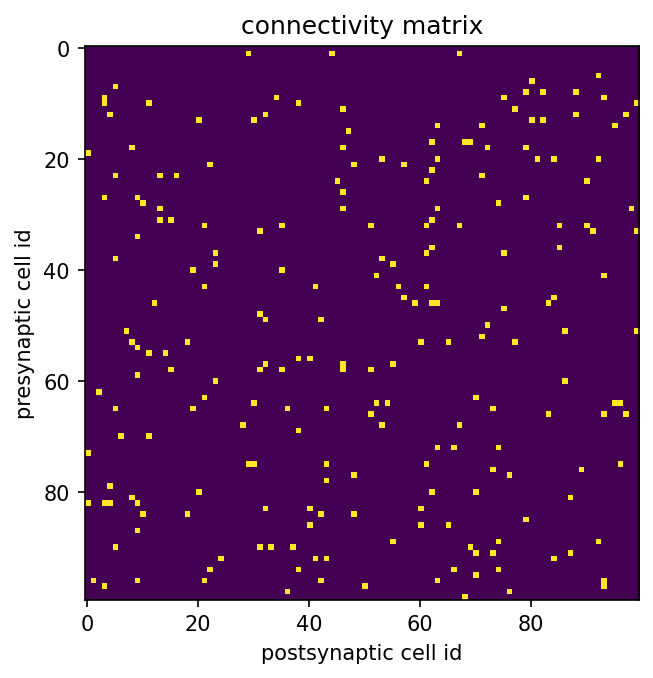

In [13]:
# we measure the following connectivity matrix
connectivity_matrix = np.random.randn(n_cells, n_cells) > 2
plt.imshow(connectivity_matrix)
plt.xlabel("postsynaptic cell id")
plt.ylabel("presynaptic cell id")
plt.title("connectivity matrix")

In [14]:
# we store the connectivity as graph (i.e. edges) because its sparse
post_cell_id, pre_cell_id = np.where(connectivity_matrix)
cell_measurements.connections.pre_cell_id = pre_cell_id
cell_measurements.connections.post_cell_id = post_cell_id

In [15]:
# the connections are now stored in our directory
cell_measurements

Directory_0000/ - Last modified: April 30, 2023 19:26:32
├── _meta.yaml
├── cell_id.h5
├── colors.h5
├── connections/
│   ├── _meta.yaml
│   ├── post_cell_id.h5
│   └── pre_cell_id.h5
├── x.h5
└── y.h5

displaying: 2 directories, 8 files

In [16]:
# to access them later from
cell_measurements.connections

connections/ - Last modified: April 30, 2023 19:26:32
├── _meta.yaml
├── post_cell_id.h5
└── pre_cell_id.h5

displaying: 1 directory, 3 files

In [17]:
# with attribute-style access
cell_measurements.connections.pre_cell_id

<HDF5 dataset "data": shape (224,), type "<i8">

In [18]:
# or composing strings following the pathlib syntax for your preference
cell_measurements / "connections/pre_cell_id"

<HDF5 dataset "data": shape (224,), type "<i8">

## Configure `Directory`s to compile their contents in explainable ways

We wrap up the code above into a coherent object that can be configured and compiled to populated `Directory`s.

In [19]:
class CellMeasurements(datamate.Directory):
    
    # default config passed to __init__
    class Config:
        n_cells: int = 100
        seed: int = 0

    # __init__ also accepts Config's attributes 
    # as key word arguments
    def __init__(self, config):
        print("Loading connectome ...")
        sleep(5)
        np.random.seed(config.seed)

        # store cell attributes
        self.cell_id = np.arange(config.n_cells)
        self.x = np.random.normal(0, 1, size=config.n_cells)
        self.y = np.random.normal(0, 1, size=config.n_cells)
        self.colors = np.random.rand(config.n_cells, 3)

        # store connectivity attributes
        connectivity_matrix = np.random.randn(config.n_cells, config.n_cells)
        pre_cell_id, post_cell_id = np.where(connectivity_matrix > 2)
        self.connections.pre_cell_id = pre_cell_id
        self.connections.post_cell_id = post_cell_id
        print("Stored connectome!")

In [20]:
# we init a Directory pointer of type 'CellMeasurements' (in the root directory).
# it's __init__ is called if a directory of this type and config does not yet exist
cell_measurements = CellMeasurements()

Loading connectome ...
Stored connectome!


In [21]:
# contents written by __init__
cell_measurements

CellMeasurements_0000/ - Last modified: April 30, 2023 19:26:38
├── _meta.yaml
├── cell_id.h5
├── colors.h5
├── connections/
│   ├── _meta.yaml
│   ├── post_cell_id.h5
│   └── pre_cell_id.h5
├── x.h5
└── y.h5

displaying: 2 directories, 8 files

In [22]:
# config written by __init__
cell_measurements.meta

Namespace(
  config = Namespace(type='CellMeasurements', n_cells=100, seed=0),
  status = 'done'
)

In [23]:
# changing the config, e.g. the seed, we get a second directory of the same type (but with different data)
cell_measurements_2 = CellMeasurements(n_cells=100, seed=42)

Loading connectome ...
Stored connectome!


In [24]:
cell_measurements_2

CellMeasurements_0001/ - Last modified: April 30, 2023 19:26:43
├── _meta.yaml
├── cell_id.h5
├── colors.h5
├── connections/
│   ├── _meta.yaml
│   ├── post_cell_id.h5
│   └── pre_cell_id.h5
├── x.h5
└── y.h5

displaying: 2 directories, 8 files

In [25]:
cell_measurements_2.meta

Namespace(
  config = Namespace(type='CellMeasurements', n_cells=100, seed=42),
  status = 'done'
)

### We can now restart the kernel and init the directory pointers to the data that has already been built to save some time next time we run the notebook.

In [26]:
from pathlib import Path
from time import sleep

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 300

import datamate

# Step 1: setting the root directory for all experimentation data.
root_dir = Path(".") / "data"
datamate.set_root_dir(root_dir)

class CellMeasurements(datamate.Directory):
    class Config:
        n_cells: int = 100
        seed: int = 0

    def __init__(self, config):
        print("Loading connectome ...")
        sleep(5)
        np.random.seed(config.seed)

        # store cell attributes
        self.cell_id = np.arange(config.n_cells)
        self.x = np.random.normal(0, 1, size=config.n_cells)
        self.y = np.random.normal(0, 1, size=config.n_cells)
        self.colors = np.random.rand(config.n_cells, 3)

        # store connectivity attributes
        connectivity_matrix = np.random.randn(config.n_cells, config.n_cells)
        pre_cell_id, post_cell_id = np.where(connectivity_matrix > 2)
        self.connections.pre_cell_id = pre_cell_id
        self.connections.post_cell_id = post_cell_id
        print("Stored connectome!")

In [27]:
# fast init because points to the directories with the same type and configuration
cell_measurements = CellMeasurements(n_cells=100, seed=0)
cell_measurements_2 = CellMeasurements(n_cells=100, seed=42)

In [28]:
cell_measurements

CellMeasurements_0000/ - Last modified: April 30, 2023 19:26:38
├── _meta.yaml
├── cell_id.h5
├── colors.h5
├── connections/
│   ├── _meta.yaml
│   ├── post_cell_id.h5
│   └── pre_cell_id.h5
├── x.h5
└── y.h5

displaying: 2 directories, 8 files

In [29]:
cell_measurements.parent

data/ - Last modified: April 30, 2023 19:26:38
├── CellMeasurements_0000/
│   ├── _meta.yaml
│   ├── cell_id.h5
│   ├── colors.h5
│   ├── connections/
│   │   ├── _meta.yaml
│   │   ├── post_cell_id.h5
│   │   └── pre_cell_id.h5
│   ├── x.h5
│   └── y.h5
├── CellMeasurements_0001/
│   ├── _meta.yaml
│   ├── cell_id.h5
│   ├── colors.h5
│   ├── connections/
│   │   ├── _meta.yaml
│   │   ├── post_cell_id.h5
│   │   └── pre_cell_id.h5
│   ├── x.h5
│   └── y.h5
└── Directory_0000/
    ├── _meta.yaml
    ├── cell_id.h5
    ├── colors.h5
    ├── connections/
    │   ├── _meta.yaml
    │   ├── post_cell_id.h5
    │   └── pre_cell_id.h5
    ├── x.h5
    └── y.h5

displaying: 7 directories, 24 files

## We set verbosity levels to navigate better through the filesystem

In [30]:
datamate.directory.set_verbosity_level(0)

In [31]:
cell_measurements.parent.parent

examples/ - Last modified: April 30, 2023 19:26:43

In [32]:
datamate.directory.set_verbosity_level(1)

In [33]:
cell_measurements.parent.parent

examples/ - Last modified: April 30, 2023 19:26:43
├── .ipynb_checkpoints/
│   ├── 01. Introduction to Datamate-checkpoint.ipynb
│   └── another thread-checkpoint.ipynb
├── 01. Introduction to Datamate.ipynb
├── another thread.ipynb
├── brainbow.png
└── data/
    ├── CellMeasurements_0000/
    │   ...
    ├── CellMeasurements_0001/
    │   ...
    └── Directory_0000/
        ...

displaying: 6 directories, 5 files, 2 levels.

In [34]:
datamate.directory.set_verbosity_level(2)

In [35]:
cell_measurements.parent.parent

examples/ - Last modified: April 30, 2023 19:26:43
├── .ipynb_checkpoints/
│   ├── 01. Introduction to Datamate-checkpoint.ipynb
│   └── another thread-checkpoint.ipynb
├── 01. Introduction to Datamate.ipynb
├── another thread.ipynb
├── brainbow.png
└── data/
    ├── CellMeasurements_0000/
    │   ├── _meta.yaml
    │   ├── cell_id.h5
    │   ├── colors.h5
    │   ├── connections/
    │   │   ├── _meta.yaml
    │   │   ├── post_cell_id.h5
    │   │   └── pre_cell_id.h5
    │   ├── x.h5
    │   └── y.h5
    ├── CellMeasurements_0001/
    │   ├── _meta.yaml
    │   ├── cell_id.h5
    │   ├── colors.h5
    │   ├── connections/
    │   │   ├── _meta.yaml
    │   │   ├── post_cell_id.h5
    │   │   └── pre_cell_id.h5
    │   ├── x.h5
    │   └── y.h5
    └── Directory_0000/
        ├── _meta.yaml
        ├── cell_id.h5
        ├── colors.h5
        ├── connections/
        │   ├── _meta.yaml
        │   ├── post_cell_id.h5
        │   └── pre_cell_id.h5
        ├── x.h5
        └── y.h5

di

## We interface to pandas for dataframe wrangling

Load the h5 data to a pandas dataframe for further processing.

In [36]:
cells = cell_measurements.to_df()
connections = cell_measurements.connections.to_df()

In [37]:
cells

,cell_id,x,y,colors
0,0,1.764052,1.883151,"[0.961936378547229, 0.29214752679254885, 0.240..."
1,1,0.400157,-1.347759,"[0.10029394226549782, 0.016429629591474204, 0...."
2,2,0.978738,-1.270485,"[0.66991654659091, 0.7851529120231378, 0.28173..."
3,3,2.240893,0.969397,"[0.5864101661863267, 0.06395526612098112, 0.48..."
4,4,1.867558,-1.173123,"[0.9774951397444468, 0.8765052453165908, 0.338..."
...,...,...,...,...
95,95,0.706573,-0.171546,"[0.5887396099702882, 0.9627703198402424, 0.016..."
96,96,0.010500,0.771791,"[0.6964824307014501, 0.8136786497018634, 0.509..."
97,97,1.785870,0.823504,"[0.33396486959680916, 0.7908401632274049, 0.09..."
98,98,0.126912,2.163236,"[0.44203563772992527, 0.5199523745708382, 0.69..."


In [38]:
connections

,post_cell_id,pre_cell_id
0,23,0
1,33,0
2,62,0
3,28,1
4,54,2
...,...,...
206,8,97
207,35,97
208,9,98
209,81,98


Load the meta data into a pandas dataframe.

In [39]:
cell_measurements.meta.to_df(name='measurements 1')

,measurements 1
status,done
config.type,CellMeasurements
config.n_cells,100
config.seed,0


In [40]:
cell_measurements_2.meta.to_df(name='measurements 2')

,measurements 2
status,done
config.type,CellMeasurements
config.n_cells,100
config.seed,42


E.g. to tabularize experiment configurations.

In [41]:
configs = cell_measurements.meta.to_df(name='measurements 1').join(cell_measurements_2.meta.to_df(name='measurements 2'))
configs

,measurements 1,measurements 2
status,done,done
config.type,CellMeasurements,CellMeasurements
config.n_cells,100,100
config.seed,0,42


Or vice versa, to create a directory from a pandas DataFrame (note, must provide [h5py compatible type information](https://docs.h5py.org/en/stable/faq.html)):

In [42]:
configs

,measurements 1,measurements 2
status,done,done
config.type,CellMeasurements,CellMeasurements
config.n_cells,100,100
config.seed,0,42


In [43]:
dtypes = {"measurements 1": 'S50', "measurements 2": 'S50'}

In [44]:
directory = datamate.Directory.from_df(configs, dtypes, "experiments_config")

In [45]:
directory

experiments_config/ - Last modified: April 30, 2023 19:26:43
├── _meta.yaml
├── measurements 1.h5
└── measurements 2.h5

displaying: 1 directory, 3 files

In [46]:
directory.to_df(dtypes={"measurements 1": str, "measurements 2": str})

,measurements 2,measurements 1
0,done,done
1,CellMeasurements,CellMeasurements
2,100,100
3,42,0


### Example: visualize the graph

In [47]:
def visualize_measurements(cell_measurements):
    try:
        import networkx as nx
    except ModuleNotFoundError as e:
        print(e, ", install networkx to visualize the cell graph structure.")
        _input = input("install now? yes/no")
        if _input == "yes":
            import sys
            !{sys.executable} -m pip install networkx[default]
            import networkx as nx
        else:
            return
        
    cells = cell_measurements.to_df()
    connections = cell_measurements.connections.to_df()
        
    G = nx.Graph()
    G.add_nodes_from(cells.cell_id)
    G.add_edges_from(connections.values)
    pos = dict(zip(cells["cell_id"].values, cells[["x", "y"]].values))

    options = {
        "font_size": 4,
        "node_size": 10,
        "node_color": cell_measurements.colors[:],
        "edgecolors": "0.5",
        "linewidths": 0.25,
        "width": 0.25,
    }
    nx.draw_networkx(G, pos, **options)

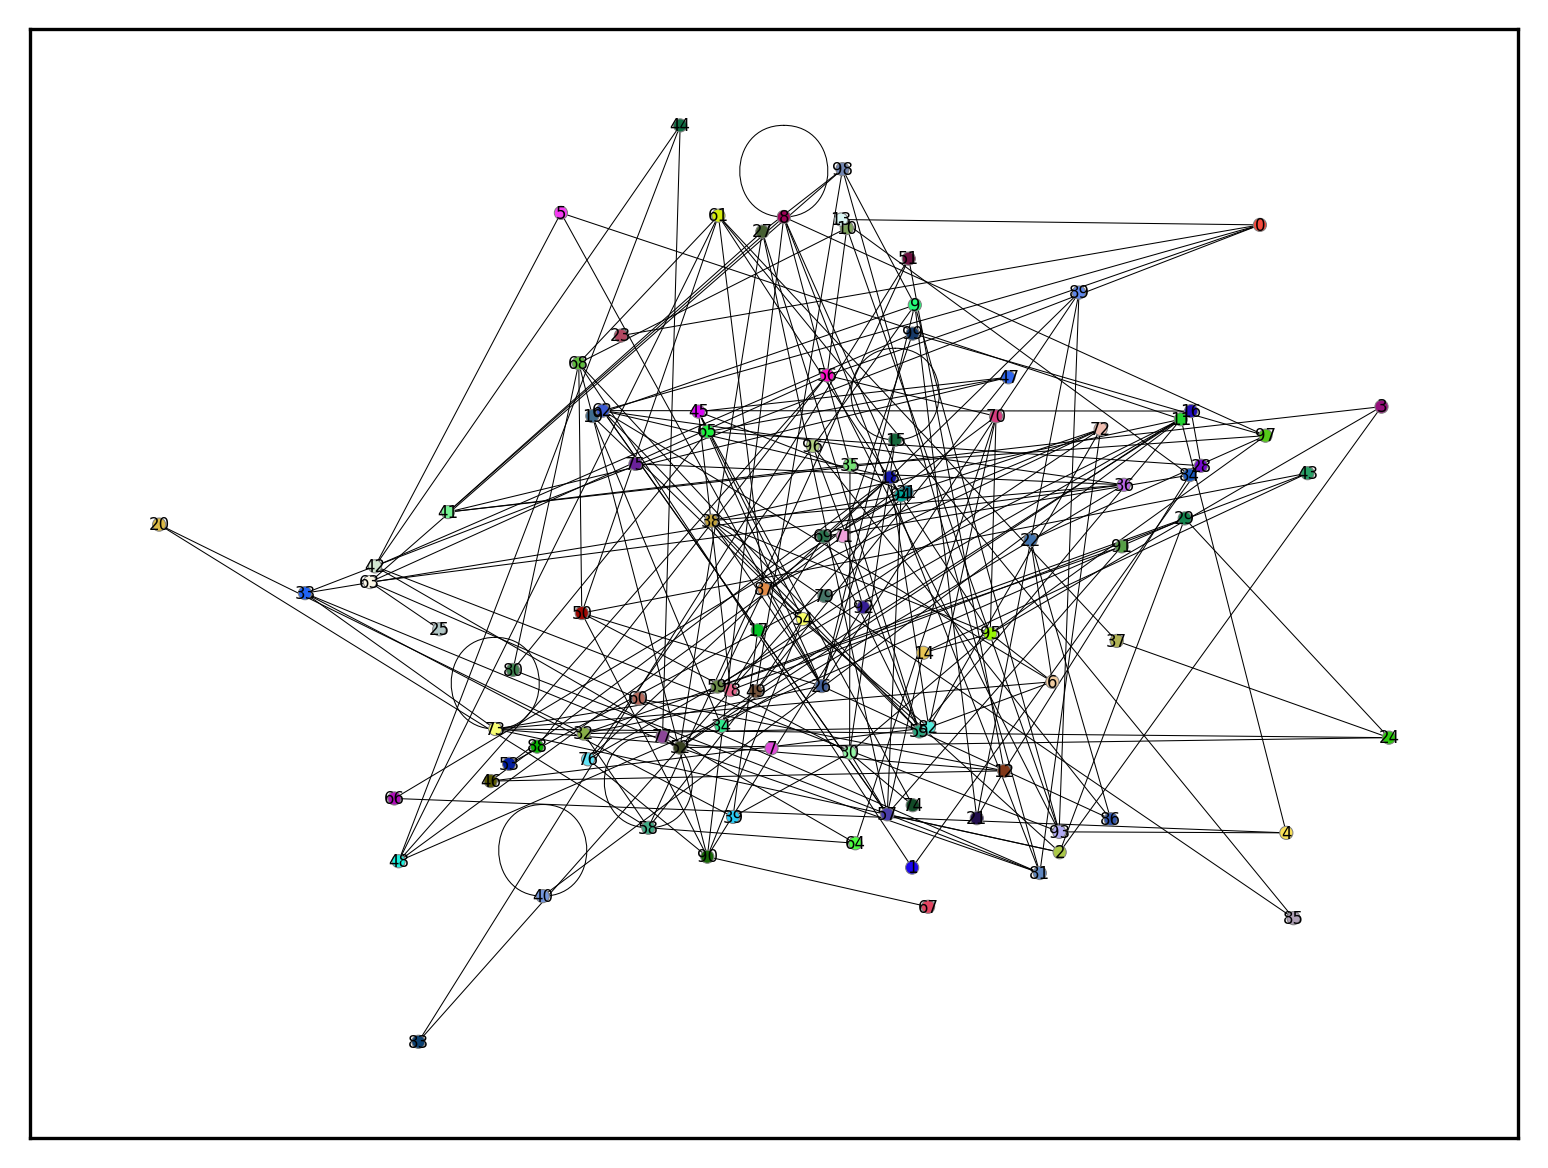

In [48]:
visualize_measurements(cell_measurements)

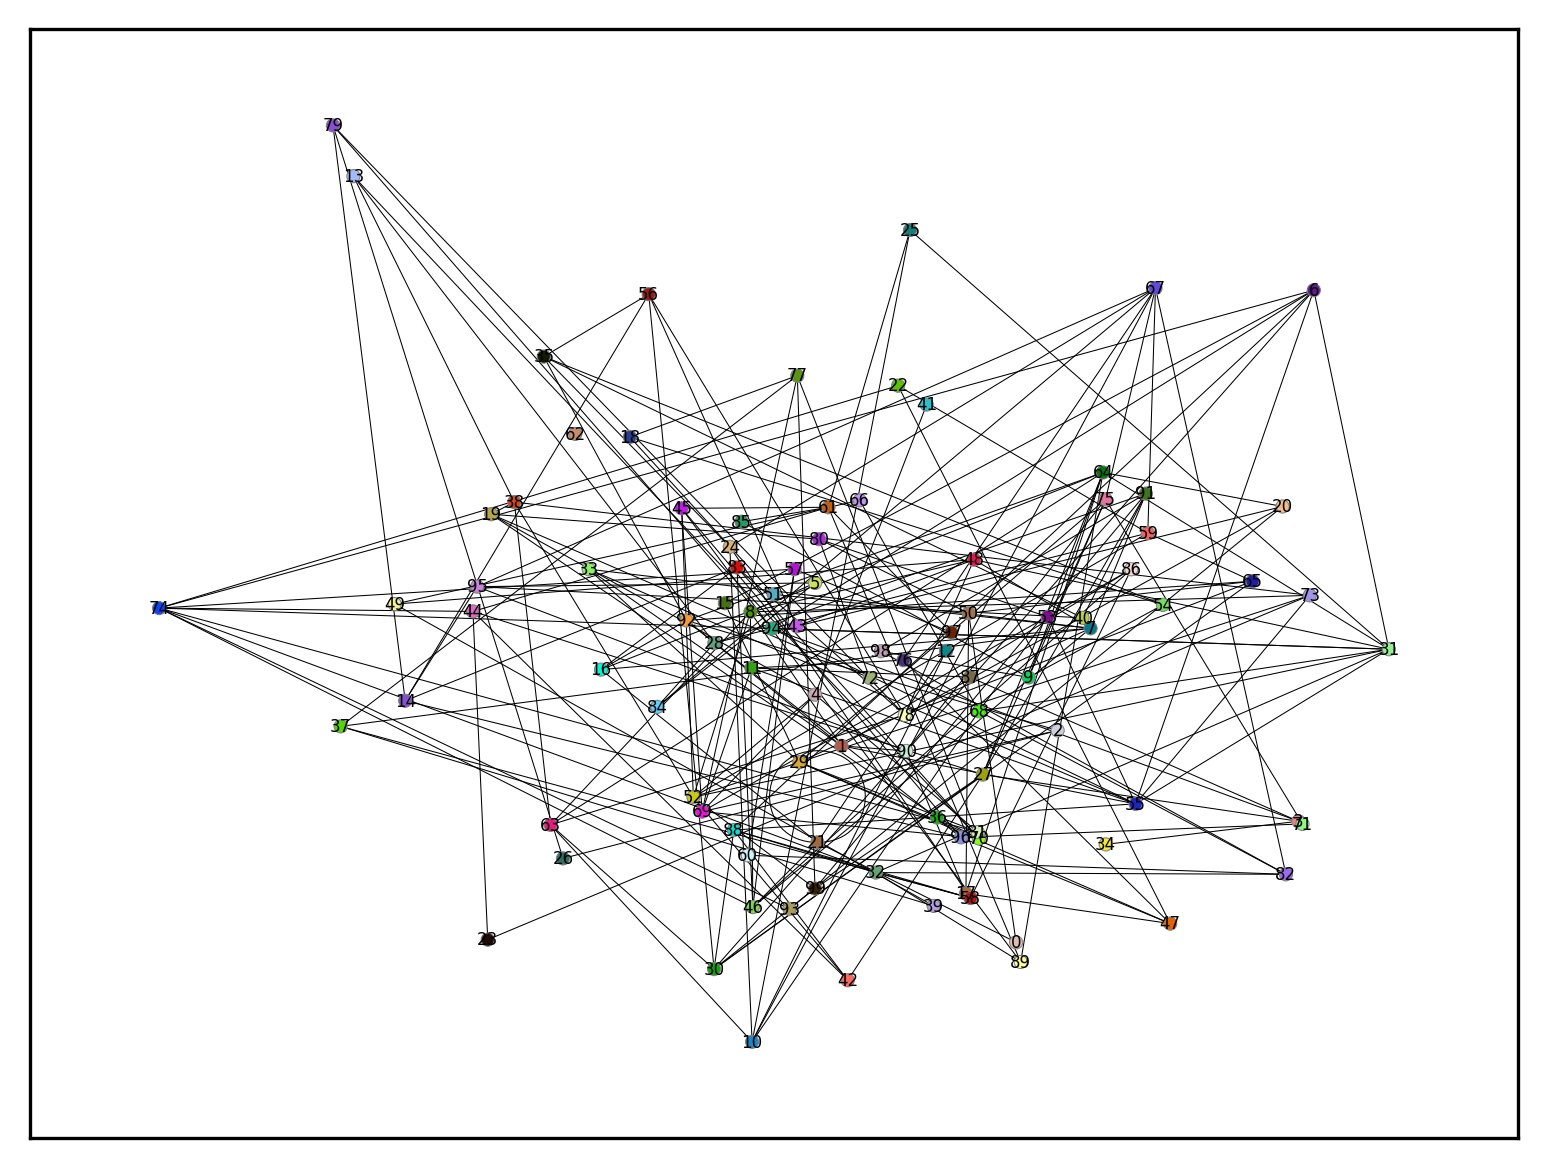

In [49]:
visualize_measurements(cell_measurements_2)

## We view diffs of configs to explain Directory contents

In [50]:
cell_measurements.meta.diff(cell_measurements_2.meta)

Namespace(self=['≠config.seed: 0'], other=['≠config.seed: 42'])

## We simultaneously write and read to monitor the data

1. Start the mockup training loop by running the cells below.
2. Start and run the jupyter notebook `another thread.ipynb` to see simultaneous write and read in action.

In [51]:
from tqdm.auto import tqdm
from time import sleep

In [52]:
class NetworkDir(datamate.Directory):
    
    class Config:
        tau: float = 200.
        sigma: float = 0.1
    
    def train(self):
        for i in tqdm(range(10000), desc="Training"):
            tnn.extend("loss", [np.exp(-i / self.config.tau) + np.random.rand() * self.config.sigma])
            sleep(0.25)

In [53]:
tnn = NetworkDir()
tnn

NetworkDir_0000/
    (path does not exist)

In [54]:
tnn.train()

KeyboardInterrupt: 